*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
1
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
2
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
3
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Warning: Reading non-scalar data in HDF5 Vector
*** Wa

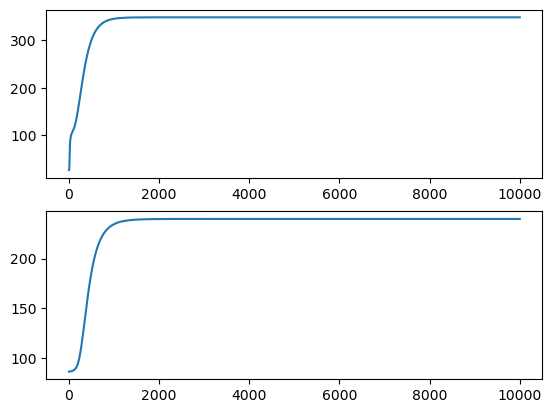

In [1]:
import sys
import numpy as np
import dolfin as d
from matplotlib import pyplot as plt
sys.path.append("/root/shared/gitrepos/smart-nanopillars/utils")
from smart_analysis import load_solution
indentation = 2.8
a0_NPC = 5.0
mesh_parent_folder = "/root/shared/gitrepos/smart-comp-sci-data/meshes/nanopillars_finalCalcCoarse"
mesh_folder = f"nanopillars_indent{indentation}"
results_parent_folder = "/root/scratch/nanopillar-sims/results_nanopillars_indentation_REDO5sens"
results_folder = f"nanopillars_indent{indentation}_a0_{a0_NPC}"
tVec = np.loadtxt(f"{results_parent_folder}/{results_folder}/tvec.txt")
stress_fiber_int = []
kNPC_int = []
if indentation > 0 and a0_NPC > 0:
    for sol in load_solution(mesh_file=f"{mesh_parent_folder}/{mesh_folder}/spreadCell_mesh.h5", 
                                results_file=[f"{results_parent_folder}/{results_folder}/FActin.h5", 
                                            f"{results_parent_folder}/{results_folder}/Myo_A.h5",
                                            f"{results_parent_folder}/{results_folder}/NPC_A.h5",
                                            f"{results_parent_folder}/{results_folder}/aNPC.h5"],
                                idx=0):
        FActin, Myo_A, NPC_A, aNPC = sol[:]
        dxCyto = d.Measure("dx", FActin.function_space().mesh())
        dxNE = d.Measure("dx", NPC_A.function_space().mesh())
        volCyto = d.assemble(1.0*dxCyto)
        stress_fiber_int.append(d.assemble(FActin*Myo_A*dxCyto)/volCyto)
        kinb = 1.0
        kin = 10.0
        kNPC_int.append(d.assemble(d.exp((aNPC-1)/a0_NPC)*(kinb + kin*NPC_A)*dxNE))
        print(len(kNPC_int))
else:
    for sol in load_solution(mesh_file=f"{mesh_parent_folder}/{mesh_folder}/spreadCell_mesh.h5", 
                                results_file=[f"{results_parent_folder}/{results_folder}/FActin.h5", 
                                            f"{results_parent_folder}/{results_folder}/Myo_A.h5",
                                            f"{results_parent_folder}/{results_folder}/NPC_A.h5"],
                                idx=0):
        FActin, Myo_A, NPC_A = sol[:]
        dxCyto = d.Measure("dx", FActin.function_space().mesh())
        dxNE = d.Measure("dx", NPC_A.function_space().mesh())
        volCyto = d.assemble(1.0*dxCyto)
        stress_fiber_int.append(d.assemble(FActin*Myo_A*dxCyto)/volCyto)
        kinb = 1.0
        kin = 10.0
        kNPC_int.append(d.assemble((kinb + kin*NPC_A)*dxNE))
        print(len(kNPC_int))


stress_fiber_int = np.array(stress_fiber_int)
NPC_int = np.array(kNPC_int)
fig, ax = plt.subplots(2,1)
ax[0].plot(tVec, stress_fiber_int)
ax[1].plot(tVec, NPC_int)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0,0
0,1
0,2
0,3
0,4
0,5
0,6
0,7
0,8
0,9
0,10
0,11
0,12
0,13
0,14
0,15
0,16
0,17
0,18
0,19
0,20
1,0
1,1
1,2
1,3
1,4
1,5
1,6
1,7
1,8
1,9
1,10
1,11
1,12
1,13
1,14
1,15
1,16
1,17
1,18
1,19
1,20
2,0
2,1
2,2
2,3
2,4
2,5
2,6
2,7
2,8
2,9
2,10
2,11
2,12
2,13
2,14
2,15
2,16
2,17
2,18
2,19
2,20
3,0
3,1
3,2
3,3
3,4
3,5
3,6
3,7
3,8
3,9
3,10
3,11
3,12
3,13
3,14
3,15
3,16
3,17
3,18
3,19
3,20
4,0
4,1
4,2
4,3
4,4
4,5
4,6
4,7
4,8
4,9
4,10
4,11
4,12
4,13
4,14
4,15
4,16
4,17
4,18
4,19
4,20
5,0
5,1
5,2
5,3
5,4
5,5
5,6
5,7
5,8
5,9
5,10
5,11
5,12
5,13
5,14
5,15
5,16
5,17
5,18
5,19
5,20
6,0
6,1
6,2
6,3
6,4
6,5
6,6
6,7
6,8
6,9
6,10
6,11
6,12
6,13
6,14
6,15
6,16
6,17
6,18
6,19
6,20
7,0
7,1
7,2
7,3
7,4
7,5
7,6
7,7
7,8
7,9
7,10
7,11
7,12
7,13
7,14
7,15
7,16
7,17
7,18
7,19
7,20
8,0
8,1
8,2
8,3
8,4
8,5
8,6
8,7
8,8
8,9
8,10
8,11
8,12
8,13
8,14
8,15
8,16
8,17
8,18
8,19
8,20
9,0
9,1
9,2
9,3
9,4
9,5
9,6
9,7
9,8
9,9
9,10
9,11
9,12
9,13
9,14
9,15
9,16
9,17
9,18
9,19
9,20
10,0
10,1
10,2
10,3
10,4
10,5
10,6
10,7
10,8
10,9


Text(0, 0.5, 'YAP/TAZ N/C')

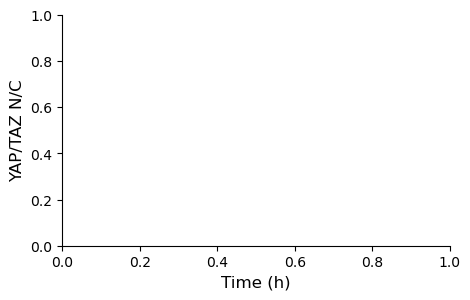

In [2]:
import matplotlib as mpl
params = {'axes.labelsize': 12,
            'axes.titlesize': 12,
            'legend.fontsize': 9,
            'xtick.labelsize':10,
            'ytick.labelsize': 10,
            'figure.figsize': (5,3),
            'pdf.fonttype': 42,
            'ps.fonttype': 42,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'legend.loc': "best"}
mpl.rcParams.update(params)
from scipy.integrate import odeint
from scipy import optimize
volCyto = d.assemble(1.0*dxCyto)
volNuc = 68.6
SANuc = d.assemble(1.0*dxNE)
geomParam = [volCyto, volNuc, SANuc, stress_fiber_int, NPC_int]

def mechanotransduction_ode_calc(timeSpan, geomParam, ruptureParam):
    # # input:
    # #     timeSpan is a vector of start and stop times (e.g. timeSpan = [0 10.0])
    # #
    # # output:
    # #     sol gives the solution computed by odeint

    Yinit = [0.2, 0.7, 0.0]
    # ode rate
    def f(Y, t, geomParam, ruptureParam):
        volCyto, volNuc, SANuc, stress_fiber_int, NPC_int =  geomParam[:]
        krupture, upsilon = ruptureParam[:]
        kNC = 0.14
        kCN = 0.56
        kCY = 7.6e-4*np.interp(t, tVec, stress_fiber_int)
        Nconvert = 602.2
        # kinb = 1.0
        # kin = 10.0
        # kin_NPC = kinb*SANuc + kin*np.interp(t, tVec, NPC_int)
        kin_NPC = np.interp(t, tVec, kNPC_int)
        kout_NPC = 1.0
        Ytot = 0.9*volCyto*Nconvert + 0.7*volNuc*Nconvert

        Y0 = (Ytot - Nconvert*(Y[0]*volCyto + (Y[1]+Y[2])*volNuc))/(Nconvert*volCyto)
        if Y0 < 0:
            print(Y0)
        dY = [kNC*Y0 - (kCN+kCY)*Y[0] + (krupture/(Nconvert*volNuc))*(Y[2] - upsilon*Y[0]),
              (1/(Nconvert*volNuc))*((kin_NPC + krupture*upsilon)*Y0 - (SANuc*kout_NPC + krupture)*Y[1]),
              (krupture/(Nconvert*volNuc))*(upsilon*Y[0] - Y[2])]
        return dY

    t = np.linspace(timeSpan[0], timeSpan[1], 1000)
    sol = odeint(f, Yinit, t, args=(geomParam,ruptureParam))
    return t, sol

def mechanotransduction_root_calc(geomParam, ruptureParam):

    Yinit = [0.2, 0.7, 0.0]
    volCyto, volNuc, SANuc, stress_fiber_int, NPC_int =  geomParam[:]
    krupture, upsilon = ruptureParam[:]
    # ode rate
    def f_res(Y):
        kNC = 0.14
        kCN = 0.56
        kCY = 7.6e-4*np.interp(1e4, tVec, stress_fiber_int)
        Nconvert = 602.2
        kin_NPC = np.interp(1e4, tVec, kNPC_int)
        kout_NPC = 1.0
        Ytot = 0.9*volCyto*Nconvert + 0.7*volNuc*Nconvert
        Y0 = (Ytot - Nconvert*(Y[0]*volCyto + (Y[1]+Y[2])*volNuc))/(Nconvert*volCyto)
        dY = [kNC*Y0 - (kCN+kCY)*Y[0] + (krupture/(Nconvert*volNuc))*(Y[2] - upsilon*Y[0]),
              (1/(Nconvert*volNuc))*((kin_NPC + krupture*upsilon)*Y0 - (SANuc*kout_NPC + krupture)*Y[1]),
              (krupture/(Nconvert*volNuc))*(upsilon*Y[0] - Y[2])]
        return dY

    sol = optimize.root(f_res, x0=Yinit)
    return sol

ode_sol = mechanotransduction_ode_calc([0, 100000], geomParam, [0.0, 0.0])
Yphos = ode_sol[1][:,0]
Ynuc = ode_sol[1][:,1]
Ynucphos = ode_sol[1][:,2]
Nconvert = 602.2
Ytot = 0.9*volCyto*Nconvert + 0.7*volNuc*Nconvert
Ydephos = (Ytot - Nconvert*(Yphos*volCyto + (Ynuc+Ynucphos)*volNuc))/(Nconvert*volCyto)
YRatioCur = (Ynuc+Ynucphos)/(Ydephos+Yphos)
YAPnopore = YRatioCur[-1]

krupture0 = np.logspace(1,3,21)
upsilon0 = np.logspace(-1,1,21)
krupture, upsilon = np.meshgrid(krupture0, upsilon0)
YAPratio = np.zeros_like(krupture)
tFinal = 3600
for i in range(len(krupture[:,0])):
    for j in range(len(krupture[0,:])):
        ode_sol = mechanotransduction_ode_calc([0, tFinal], geomParam, [krupture[i,j], upsilon[i,j]])
        Yphos = ode_sol[1][:,0]
        Ynuc = ode_sol[1][:,1]
        Ynucphos = ode_sol[1][:,2]
        Ydephos = (Ytot - Nconvert*(Yphos*volCyto + (Ynuc+Ynucphos)*volNuc))/(Nconvert*volCyto)
        YRatioCur = (Ynuc+Ynucphos)/(Ydephos+Yphos)
        # plt.plot(ode_sol[0]/3600, YRatioCur)
        YAPratio[i,j] = YRatioCur[-1]
        # root_sol = mechanotransduction_root_calc(geomParam, [krupture[i,j], upsilon[i,j]])
        # Yphos, Ynuc, Ynucphos = root_sol.x
        # Ydephos = (Ytot - Nconvert*(Yphos*volCyto + (Ynuc+Ynucphos)*volNuc))/(Nconvert*volCyto)
        # YRatioCur = (Ynuc+Ynucphos)/(Ydephos+Yphos)
        # YAPratio[i,j] = YRatioCur
        # plt.plot(3, YAPratio[i,j], 'o')

        print(f"{i},{j}")

pore_dir = f"/root/shared/gitrepos/smart-nanopillars/analysis_data/npy-files-nanopillars-withwasp-pores"
r0 = np.array([0.1, 0.2])
k0 = np.array([10000, 10000])
krupture0Sim = k0*np.pi*r0**2 / 8
upsilon0Sim = [1.0, 5.0]
kruptureSim, upsilonSim = np.meshgrid(krupture0Sim, upsilon0Sim)
rMat, upsilon1 = np.meshgrid(r0, upsilon0Sim)
kMat, upsilon2 = np.meshgrid(k0, upsilon0Sim)
YAPratioSim = np.zeros_like(kruptureSim)

for i in range(len(kruptureSim[:,0])):
    for j in range(len(kruptureSim[0,:])):
        var_names_saved = ["YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_nuc_phos", "YAPTAZ_phos"]
        plot_names = ["YAPTAZ_phos", "YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_nuc_phos"]

        cur_file = (f"nanopillars_indent{indentation}_pore_size{rMat[i,j]}_"
                f"loc0.0_rate1_transport{kMat[i,j]}_"
                f"ratio{upsilonSim[i,j]:.0f}_results_all.npy")
        cur_file = f"{pore_dir}/{cur_file}"
        try:
            results_cur = np.load(cur_file)
            tSim, YAPnp, YAPnuc, YAPphos_nuc, YAPphos = results_cur[:]
            YAPratioSimCur = (YAPnuc + YAPphos_nuc) / (YAPphos + YAPnp)
            # plt.plot(tSim/3600, YAPratioSimCur, '--')
            YAPratioSim[i,j] = np.interp(tFinal, tSim, YAPratioSimCur)
        except:
            print("could not load")

plt.xlim([0, 1])
plt.xlabel('Time (h)')
plt.ylabel('YAP/TAZ N/C')
# plt.ylim([2.8, 3.8])

# plt.figure()
# for i in range(len(krupture0)):
#     plt.plot(upsilon[:,i], YAPratio[:,i])
#     plt.plot(upsilon[:,i], YAPratioSim[:,i], '--')
# plt.savefig("200nm_10000.pdf", format="pdf")

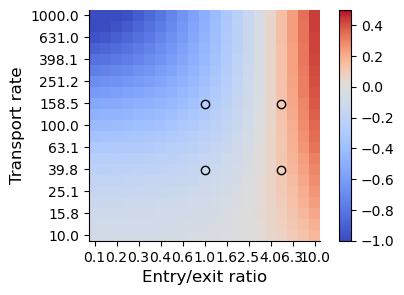

In [3]:
from matplotlib.colors import ListedColormap
plt.figure()
cmap_cur = plt.get_cmap('coolwarm')
cmap_big = mpl.colormaps['coolwarm']
upper_lower_ratio = 0.5
clist1 = cmap_big(np.linspace(0, 0.5, 128))
clist2 = cmap_big(np.linspace(0.5, 1.0, int(upper_lower_ratio*128)))
newcmp = ListedColormap(np.concatenate((clist1, clist2[1:])))
logFoldVals = np.linspace(-1, 1*upper_lower_ratio, len(newcmp.colors))
cVals = np.linspace(0, 1, len(newcmp.colors))

ax = plt.axes()
logFoldChange = np.log10(YAPratio / YAPnopore)
im = plt.imshow(logFoldChange.transpose(), cmap = newcmp)
plt.colorbar(im)
plt.ylim([-0.5,len(krupture0)-0.5])
plt.clim([-1, 1*upper_lower_ratio])
xvals = np.arange(0,len(upsilon0),1)
xlabels = []
for i in range(len(xvals)):
    xlabels.append(f"{upsilon0[i]:.1f}")
plt.xlabel('Entry/exit ratio')
yvals = np.arange(0,len(krupture0),1)
ylabels = []
for i in range(len(yvals)):
    ylabels.append(f"{krupture0[i]:.1f}")
plt.ylabel('Transport rate')
plt.xticks(xvals[0::2], xlabels[0::2])
plt.yticks(yvals[0::2], ylabels[0::2])

logFoldChangeSim = np.log10(YAPratioSim / YAPnopore)
for i in range(len(kruptureSim[:,0])):
    for j in range(len(kruptureSim[0,:])):
        upsilonScaled = np.interp(np.log(upsilonSim[i,j]), np.log(upsilon0), xvals)
        kruptureScaled = np.interp(np.log(kruptureSim[i,j]), np.log(krupture0), yvals)
        colorVal = np.interp(logFoldChangeSim[i,j], logFoldVals, cVals)
        plt.plot(upsilonScaled, kruptureScaled, 'o', color=newcmp(colorVal), mec='k')
# plt.savefig("pore_phase_diagram_newColorWithPoints.pdf", format="pdf")